<a href="https://colab.research.google.com/github/halimcan/Home-Credit-Default-Project/blob/previous_application_branch4/previous_applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installments of required tables
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#  BigQuery API activation
from google.colab import auth
auth.authenticate_user()


In [3]:
# big query add-on installation

!pip install --quiet google-cloud-bigquery
from google.cloud import bigquery

In [4]:
# BigQuery client initiation
client = bigquery.Client(project="homecredit-478707")

# From BigQuery
query = """
SELECT *
FROM `homecredit-478707.Homecredit_Tables.previous_application`
"""
previous_application = client.query(query).to_dataframe()

# EDA

Primary Key Check

In [5]:
# SK_ID_PREV is unique?

print("Unique SK_ID_PREV:", previous_application['SK_ID_PREV'].nunique())
print("Total rows:", previous_application.shape[0])

Unique SK_ID_PREV: 1670214
Total rows: 1670214


The SK_ID_PREV column is a perfect primary key at the loan-level. Each row represents a unique previous application, with no duplicates among the 1,670,214 records

In [6]:
# How many applicatios per customer
prev_counts = previous_application.groupby('SK_ID_CURR').size()


In [7]:
print(prev_counts.describe())

count    338857.000000
mean          4.928964
std           4.220716
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          77.000000
dtype: float64


Each customer has made multiple previous applications, with an average of ~5 per customer. While most customers have between 2 and 7 applications, some outliers exist with up to 77 applications. This confirms the need for customer-level aggregation to create meaningful features for credit risk modeling.

# Data Types & Null Check

In [8]:
# Data types
print(previous_application.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  Int64  
 1   SK_ID_CURR                   1670214 non-null  Int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  Int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  boolean
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  Int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [9]:
# Null ratios
null_ratio = previous_application.isnull().mean().sort_values(ascending=False)
null_ratio

,0
RATE_INTEREST_PRIVILEGED,9.964370e-01
RATE_INTEREST_PRIMARY,9.964370e-01
AMT_DOWN_PAYMENT,5.363648e-01
RATE_DOWN_PAYMENT,5.363648e-01
NAME_TYPE_SUITE,4.911975e-01
DAYS_TERMINATION,4.029813e-01
DAYS_FIRST_DRAWING,4.029813e-01
DAYS_FIRST_DUE,4.029813e-01
DAYS_LAST_DUE_1ST_VERSION,4.029813e-01
DAYS_LAST_DUE,4.029813e-01


Some columns have extremely high missing rates (over 99%), like RATE_INTEREST_PRIVILEGED and RATE_INTEREST_PRIMARY, which are almost entirely empty and not useful for modeling.

Columns like AMT_DOWN_PAYMENT, RATE_DOWN_PAYMENT, NAME_TYPE_SUITE, and DAYS_TERMINATION have 22–53% missing values. These may require imputation or careful handling during feature engineering.

Core columns like SK_ID_PREV, SK_ID_CURR, AMT_CREDIT, AMT_APPLICATION, NAME_CONTRACT_TYPE, and DAYS_DECISION are fully populated and suitable for aggregation into customer-level features.

This missing value analysis guides which features to aggregate, impute, or exclude, ensuring robust credit risk features at the customer level.

Before imputing missing values, we analyze their distribution and meaning. Some missing values represent actual events (like not having a down payment or not terminating a credit), while others are random. This informs how we impute or flag missing data for feature engineering

# Drop variables with missing values > %70, and visualizations

Dropping columns with >70% missing:
['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']

Columns with 20–70% missing:
['AMT_ANNUITY', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'RATE_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']

Columns with 0–20% missing:
['AMT_CREDIT', 'PRODUCT_COMBINATION']

==== AMT_ANNUITY ====


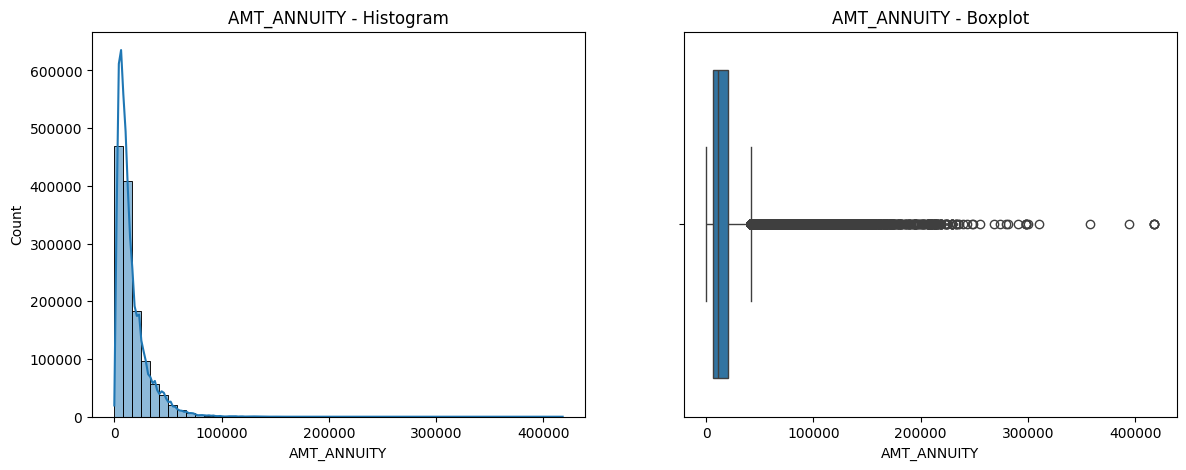

Outlier count: 82762

==== AMT_DOWN_PAYMENT ====


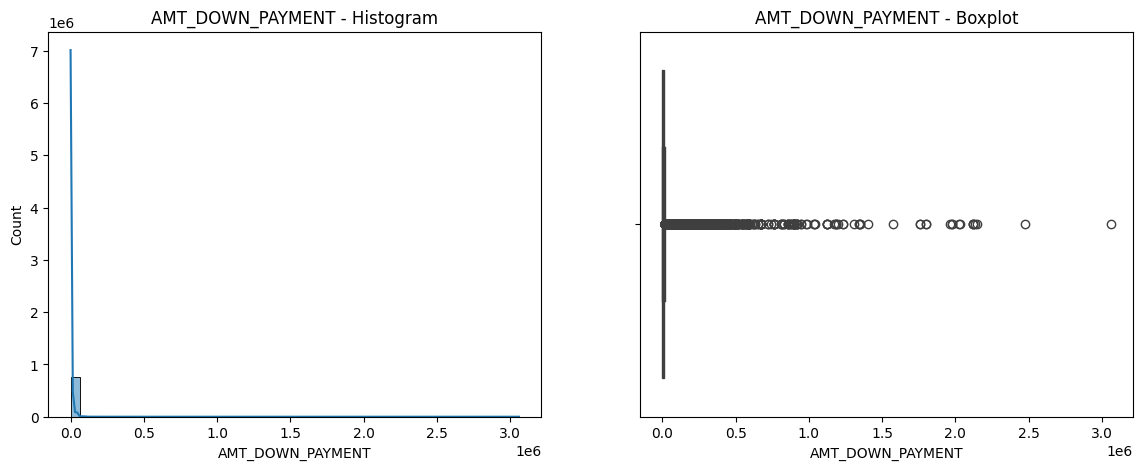

Outlier count: 64402

==== AMT_GOODS_PRICE ====


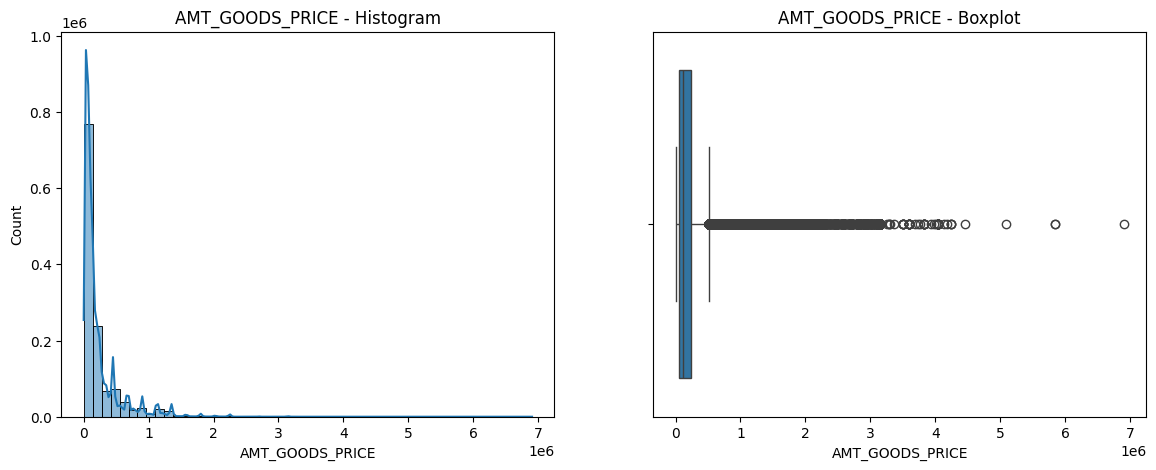

Outlier count: 145715

==== RATE_DOWN_PAYMENT ====


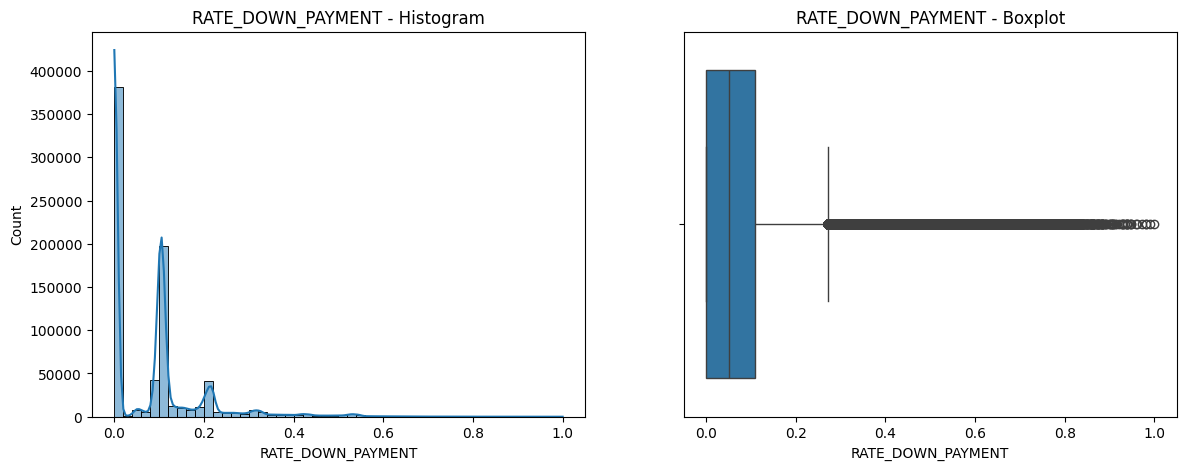

Outlier count: 43162

Skipping non-numeric column: NAME_TYPE_SUITE

==== CNT_PAYMENT ====


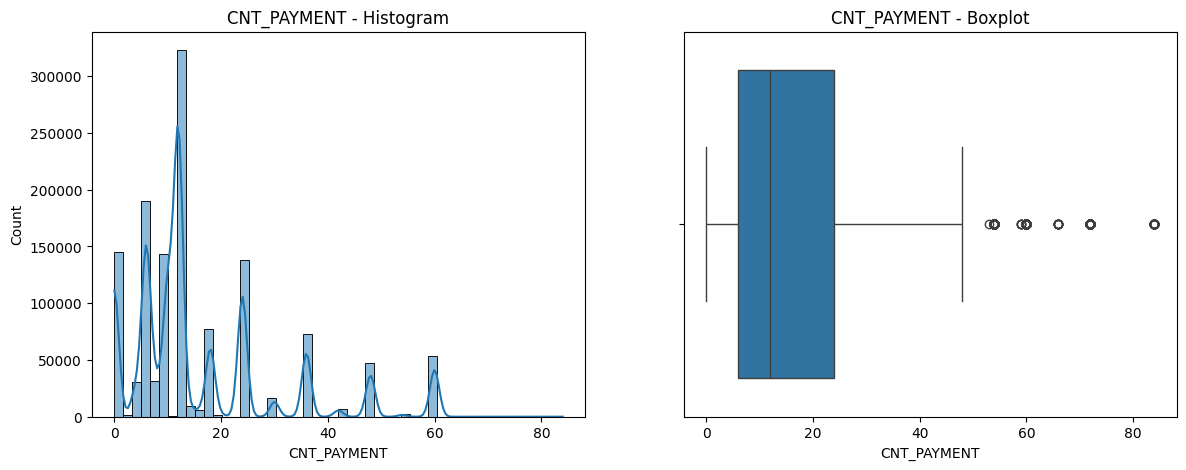

Outlier count: 55903

==== DAYS_FIRST_DRAWING ====


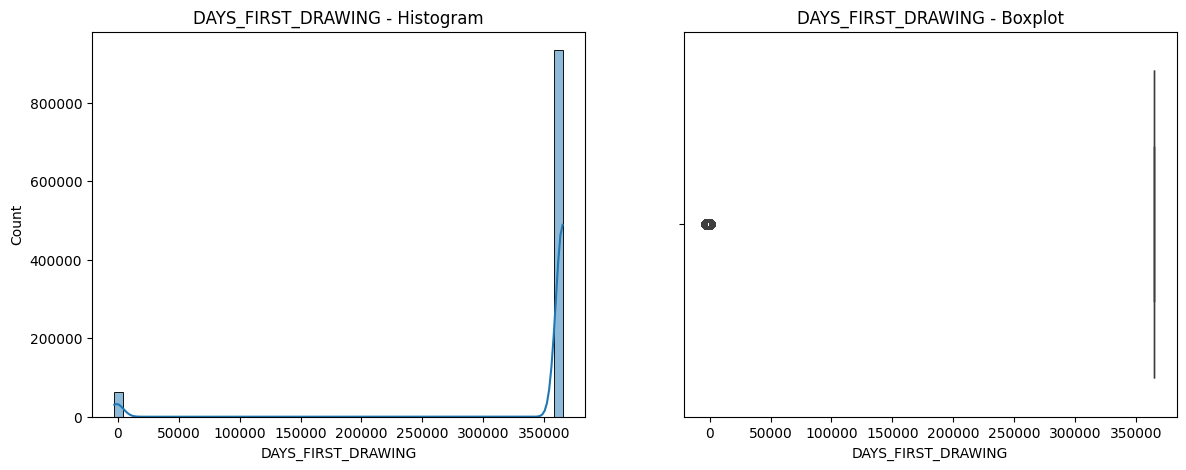

Outlier count: 62705

==== DAYS_FIRST_DUE ====


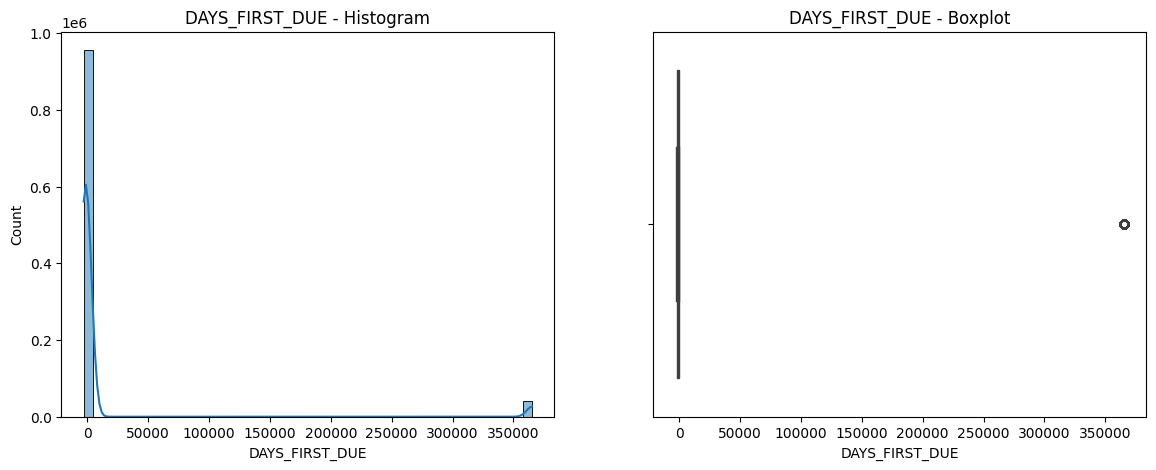

Outlier count: 40645

==== DAYS_LAST_DUE_1ST_VERSION ====


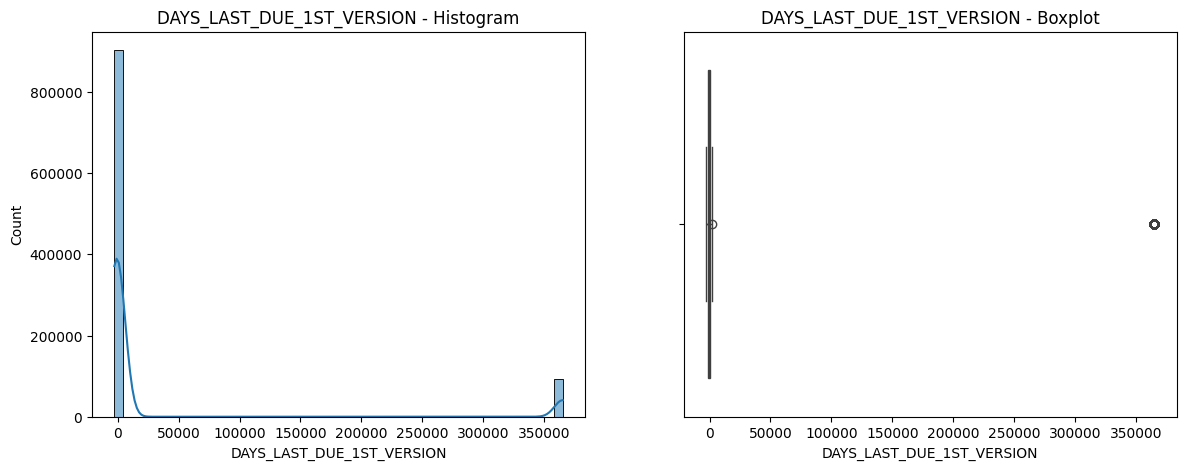

Outlier count: 93865

==== DAYS_LAST_DUE ====


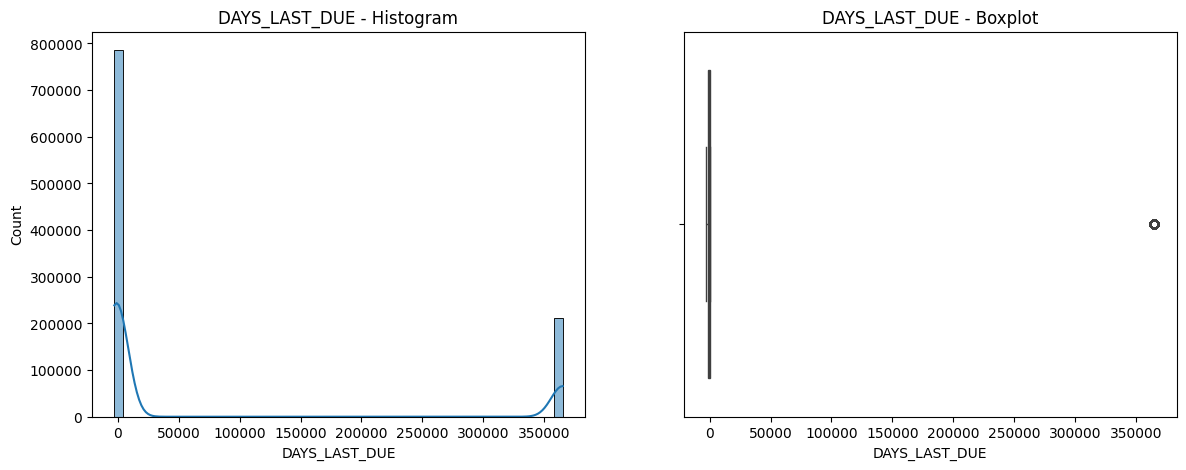

Outlier count: 211221

==== DAYS_TERMINATION ====


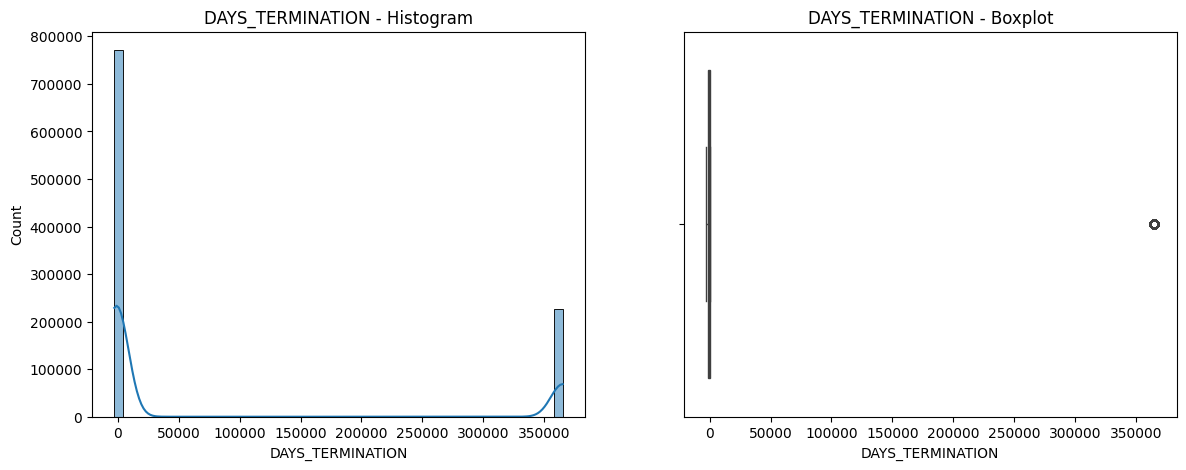

Outlier count: 225913

==== NFLAG_INSURED_ON_APPROVAL ====


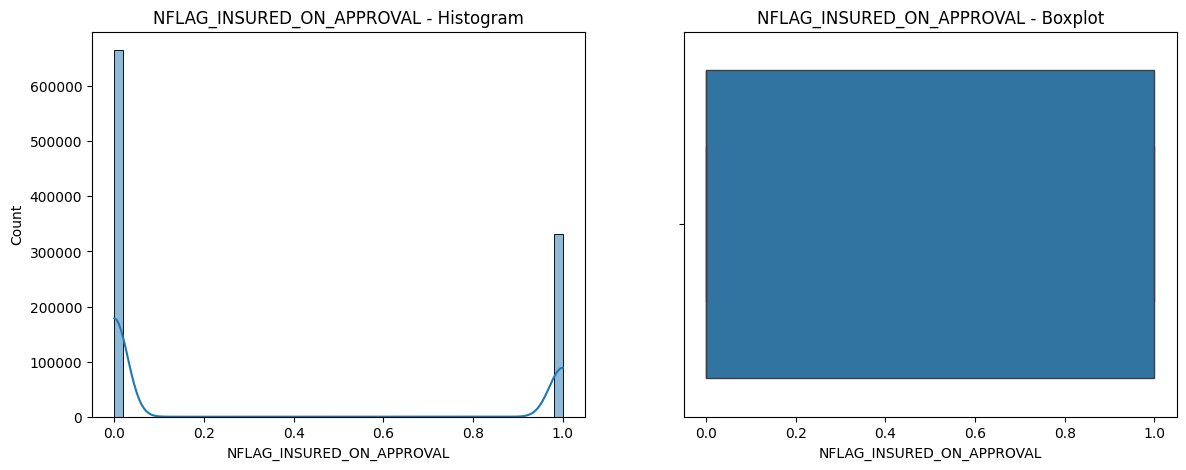

Outlier count: 0

==== AMT_CREDIT ====


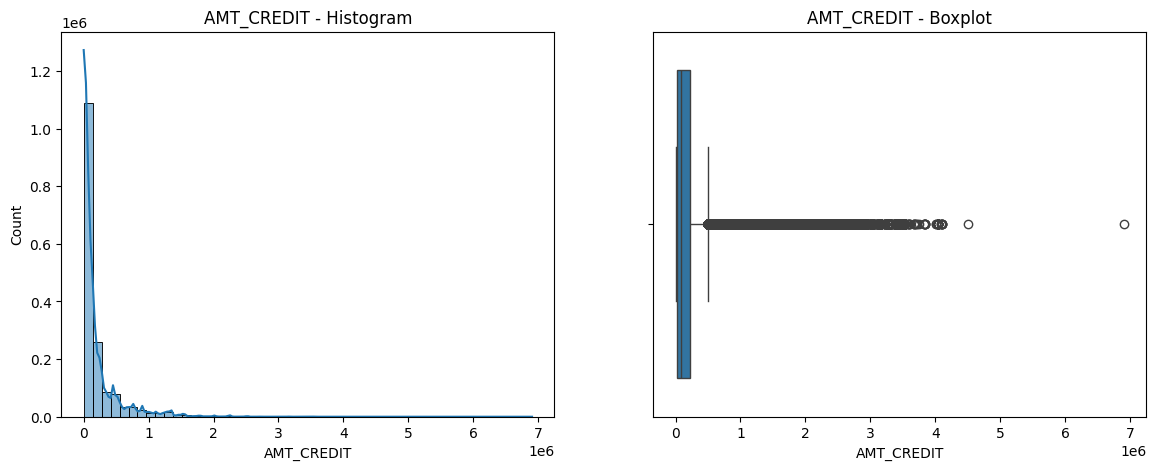

Outlier count: 179989

Skipping non-numeric column: PRODUCT_COMBINATION


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the correct dataset name
df = previous_application

# -----------------------------
# 1. Missing value analysis
# -----------------------------
missing_percent = df.isnull().mean() * 100

# Columns with >70% missing → Drop
high_missing_cols = missing_percent[missing_percent > 70].index.tolist()
print("Dropping columns with >70% missing:")
print(high_missing_cols)

df_clean = df.drop(columns=high_missing_cols)

# Mid missing (20–70%)
mid_missing_cols = missing_percent[(missing_percent > 20) & (missing_percent <= 70)].index.tolist()
print("\nColumns with 20–70% missing:")
print(mid_missing_cols)

# Low missing (0–20%)
low_missing_cols = missing_percent[(missing_percent > 0) & (missing_percent <= 20)].index.tolist()
print("\nColumns with 0–20% missing:")
print(low_missing_cols)


# -------------------------------------------------------------
# Function: histogram + boxplot + outlier report for each column
# -------------------------------------------------------------
def plot_dist_and_outliers(df, cols):
    for col in cols:
        # Only analyze numeric columns
        if df[col].dtype not in ['float64', 'int64']:
            print(f"\nSkipping non-numeric column: {col}")
            continue

        print(f"\n==== {col} ====")

        # Plot histogram & boxplot
        plt.figure(figsize=(14,5))

        # Histogram
        plt.subplot(1,2,1)
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f"{col} - Histogram")

        # Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=df[col])
        plt.title(f"{col} - Boxplot")

        plt.show()

        # Outlier detection (IQR rule)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outlier_count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        print(f"Outlier count: {outlier_count}")


# ------------------------------------------
# 2. Run EDA for mid-missing numeric columns
# ------------------------------------------
plot_dist_and_outliers(df_clean, mid_missing_cols)

# ------------------------------------------
# 3. Run EDA for low-missing numeric columns
# ------------------------------------------
plot_dist_and_outliers(df_clean, low_missing_cols)


In [13]:
# ============================================================
# previous_application: Data Cleaning + Feature Engineering Pipeline
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 0) Load dataset: use in-memory DataFrame if exists, else read
# ------------------------------------------------------------
try:
    df = previous_application.copy()
    print("Using in-memory DataFrame: previous_application")
except NameError:
    csv_path = "/mnt/data/previous_application.csv"   # <-- this is your uploaded local file
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset from {csv_path}")

# ------------------------------------------------------------
# 1) Identify numeric & categorical columns
# ------------------------------------------------------------
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ------------------------------------------------------------
# 2) Drop columns with >70% missing
# ------------------------------------------------------------
missing_ratio = df.isna().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.70].index.tolist()

df.drop(columns=cols_to_drop, inplace=True)
print("Dropped columns (>70% missing):", cols_to_drop)

# refresh lists
num_cols = [c for c in num_cols if c not in cols_to_drop]
cat_cols = [c for c in cat_cols if c not in cols_to_drop]

# ------------------------------------------------------------
# 3) Medium-missing columns (20–70%)
#    Numeric  → sentinel -999
#    Categorical → "Unknown"
# ------------------------------------------------------------
medium_missing = missing_ratio[(missing_ratio > 0.20) & (missing_ratio <= 0.70)].index.tolist()
print("Medium-missing columns (20–70%):", medium_missing)

for col in medium_missing:
    if col in num_cols:
        df[col] = df[col].fillna(-999)  # domain-aware sentinel
    elif col in cat_cols:
        df[col] = df[col].fillna("Unknown")

# ------------------------------------------------------------
# 4) Low-missing columns (<20%)
#    Numeric → median
#    Categorical → "Unknown"
# ------------------------------------------------------------
low_missing = missing_ratio[(missing_ratio > 0) & (missing_ratio <= 0.20)].index.tolist()
print("Low-missing columns (0–20%):", low_missing)

for col in low_missing:
    if col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    elif col in cat_cols:
        df[col] = df[col].fillna("Unknown")

# ------------------------------------------------------------
# 5) Safety pass (ensure no NA left)
# ------------------------------------------------------------
for col in df.columns:
    if df[col].isna().any():
        if col in num_cols:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna("Unknown")

# ------------------------------------------------------------
# 6) Outliers
#    DO NOT remove outliers — credit data extremes contain real signal.
# ------------------------------------------------------------
print("Outliers preserved (no removal).")

# ------------------------------------------------------------
# 7) Basic Feature Engineering for previous_application
# ------------------------------------------------------------

# Flag: was the application approved?
if "NAME_CONTRACT_STATUS" in df.columns:
    df["APPROVED_FLAG"] = (df["NAME_CONTRACT_STATUS"] == "Approved").astype(int) # A loan application being approved or not is one of the strongest behavioral signals for credit scoring/1 if application approved, 0 otherwise

# Credit to goods price ratio
if "AMT_CREDIT" in df.columns and "AMT_GOODS_PRICE" in df.columns:
    df["CREDIT_GOODS_RATIO"] = df["AMT_CREDIT"] / (df["AMT_GOODS_PRICE"] + 1) # This ratio measures what fraction of the goods price is being financed through credit/A higher ratio often indicates higher financial dependency and therefore higher risk.

# Application processing duration example
if "DAYS_DECISION" in df.columns:
    df["FAST_DECISION_FLAG"] = (df["DAYS_DECISION"] > -5).astype(int) # Captures how quickly the lender made a decision.Explanation:DAYS_DECISION close to zero means the institution approved/rejected
                                                                        #the application very quickly, which may indicate: pre-approved loans, automated risk flags,high-risk or low-risk customers depending
                                                                        # on lending policy.This becomes a useful proxy for lender confidence.

# Annuity ratio if exists
if "AMT_ANNUITY" in df.columns and "AMT_CREDIT" in df.columns:
    df["ANNUITY_CREDIT_RATIO"] = df["AMT_ANNUITY"] / (df["AMT_CREDIT"] + 1) # Explanation:Represents the monthly burden relative to total loan amount. Higher ratios imply higher payment pressure,
                                                                            #which is a strong indicator for repayment capacity and default risk.

# ------------------------------------------------------------
# 8) Convert categorical columns to category for modelling
# ------------------------------------------------------------
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype("category")

# ------------------------------------------------------------
# 9) Output
# ------------------------------------------------------------
print("Final shape:", df.shape)
print("Preview columns:", df.columns[:30].tolist())

# assign back to original variable
previous_application = df

# optional save
df.to_csv("previous_application_cleaned.csv", index=False)

print("Cleaning + feature engineering for previous_application completed.")


Using in-memory DataFrame: previous_application
Dropped columns (>70% missing): []
Medium-missing columns (20–70%): []
Low-missing columns (0–20%): []
Outliers preserved (no removal).
Final shape: (1670214, 39)
Preview columns: ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING']
Cleaning + feature engineering for previous_application completed.


Feature Engineering + Aggregations

In [14]:
import pandas as pd
import numpy as np

# -------------------------
# 1) Identify variable types
# -------------------------

numeric_cols = previous_application.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = previous_application.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove customer ID from FE lists
numeric_cols = [col for col in numeric_cols if col not in ["SK_ID_CURR", "SK_ID_PREV"]]
categorical_cols = [col for col in categorical_cols if col not in ["SK_ID_CURR", "SK_ID_PREV"]]

# --------------------------------------
# 2) Numeric feature aggregation rules
# --------------------------------------

num_aggs = {}

for col in numeric_cols:
    num_aggs[col] = ["mean", "std", "min", "max", "median"]

# ---------------------------------------------------
# 3) Categorical variable encoding (One-Hot + agg)
# ---------------------------------------------------

# Convert to string to avoid errors
previous_application[categorical_cols] = previous_application[categorical_cols].astype(str)

# One-hot encode categorical variables
previous_ohe = pd.get_dummies(previous_application, columns=categorical_cols, dummy_na=False)

# Keep only OHE columns (exclude numeric)
ohe_cols = [col for col in previous_ohe.columns if any(cat in col for cat in categorical_cols)]

# ---------------------------------------
# 4) Aggregate numeric features per client
# ---------------------------------------

numeric_agg_df = previous_application.groupby("SK_ID_CURR").agg(num_aggs)
numeric_agg_df.columns = ["PREV_" + "_".join(col).upper() for col in numeric_agg_df.columns]

# -------------------------------------------------
# 5) Aggregate one-hot encoded (categorical) features
# -------------------------------------------------

categorical_agg_df = previous_ohe.groupby("SK_ID_CURR")[ohe_cols].mean()
categorical_agg_df.columns = ["PREV_" + col.upper() + "_MEAN" for col in categorical_agg_df.columns]

# -------------------------------------------------
# 6) Combine numeric + categorical customer features
# -------------------------------------------------

previous_agg = pd.concat([numeric_agg_df, categorical_agg_df], axis=1)

print(previous_agg.shape)
previous_agg.head()


(338857, 250)


,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_STD,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEDIAN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_STD,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEDIAN,...,PREV_PRODUCT_COMBINATION_CASH X-SELL: MIDDLE_MEAN,PREV_PRODUCT_COMBINATION_POS HOUSEHOLD WITH INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS HOUSEHOLD WITHOUT INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS INDUSTRY WITH INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS INDUSTRY WITHOUT INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS MOBILE WITH INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS MOBILE WITHOUT INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS OTHER WITH INTEREST_MEAN,PREV_PRODUCT_COMBINATION_POS OTHERS WITHOUT INTEREST_MEAN,PREV_PRODUCT_COMBINATION_UNKNOWN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,NaN,3951.000,3951.000,3951.000,24835.50,NaN,24835.5,24835.5,24835.50,...,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
100002,9251.775,NaN,9251.775,9251.775,9251.775,179055.00,NaN,179055.0,179055.0,179055.00,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
100003,56553.990,46332.557777,6737.310,98356.995,64567.665,435436.50,424161.620549,68809.5,900000.0,337500.00,...,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
100004,5357.250,NaN,5357.250,5357.250,5357.250,24282.00,NaN,24282.0,24282.0,24282.00,...,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
100005,1907.100,4109.846034,-999.000,4813.200,1907.100,22308.75,31549.336810,0.0,44617.5,22308.75,...,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0


The previous_application table consists of loan-level historical credit applications, where each customer may have multiple past requests. To make this information usable for a credit risk model, I transformed the raw loan records into customer-level behavioral features.

• I applied domain-aware missing value strategies, removed columns with extremely high missing rates, preserved natural credit outliers, and created engineered features such as approval flags, credit-to-goods ratios, and annuity-to-credit ratios.

• Using one-hot encoded category distributions and numeric aggregations (mean, max, std, median), I generated customer-level summary metrics such as approval rates, average past credit amounts, decision speed patterns, and loan purpose usage profiles — all of which are powerful predictors of repayment behavior.

• The result is a clean, enriched, customer-level feature set (previous_agg) ready to be merged into the main application dataset, significantly enhancing the overall predictive power of the credit scoring model.

In [ ]:
# to merge

# application_train = application_train.merge(previous_agg, on="SK_ID_CURR", how="left")